In [1]:
# IMPORTING MODULES
import glob
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
cvx_path = os.path.abspath(os.path.join('..', '..', 'cvxEDA', 'src'))
module_path = os.path.abspath(os.path.join('..', '..', 'src'))
import pandas as pd
import random
import scipy.signal as ss
import shap
import sys
sys.path.append(module_path)

import tools.data_reader_wesad as dr_w
import tools.data_reader_ascertain as dr_asc
import tools.display_tools as dt
import tools.preprocessing as preprocessing
import train

from scipy.fft import fft, fftfreq, fftshift
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.preprocessing import normalize
from xgboost import XGBClassifier

import cvxopt.solvers
cvxopt.solvers.options['show_progress'] = False

import warnings
warnings.filterwarnings(
    "ignore", 
    category=RuntimeWarning
)
warnings.simplefilter(action='ignore', category=FutureWarning)# IMPORTING MODULES

c:\Users\zhoux\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
metrics = [
    train.Metrics.BPM, 
    train.Metrics.RMSSD, 
    train.Metrics.HF_RR, 
    train.Metrics.LF_RR, 
    # train.Metrics.IBI, 
    train.Metrics.SDNN, 
    train.Metrics.MEAN_SCL, 
    train.Metrics.SCR_RATE
]

model_phases_wesad = dr_w.Phases.PHASE_ORDER

wesad_label_type = "stai"
asc_label_type = dr_asc.SelfReports.AROUSAL

models = {
    # "SVM": SVC(C=10, gamma=1),  # C=10, gamma=1
    # "KNN": KNeighborsClassifier(n_neighbors=7),
    # "DT": DecisionTreeClassifier(),
    "LogReg": LogisticRegression(max_iter=1000),
    # "Bayes": GaussianNB(),
    "RF": RandomForestClassifier(),
    "XGB": XGBClassifier(use_label_encoder=False, objective="binary:logistic", eval_metric="logloss")
}

threshold = "fixed"
asc_threshold = "fixed"
test_size = 1.0


In [ ]:
importlib.reload(train)
importlib.reload(dr_w)

stai_scores, dim_scores_arousal, dim_scores_valence = train.Train_WESAD.get_labels(model_phases_wesad)
print(stai_scores)

y_train:
1    1522
0     262
Name: label, dtype: int64
y_test:
0    55
1    15
Name: label, dtype: int64
Model LogReg, Predictions: [0 1], [10 60]
Calculating shap values
Model RF, Predictions: [0 1], [14 56]
Calculating shap values
Model XGB, Predictions: [0 1], [10 60]
Calculating shap values
[[-0.09272023 -1.43579812  0.00368964  0.52473493 -1.13860747 -1.32889041
   0.40319343 -0.62146512]]
[0.1355303  0.14679052 0.11812456 0.11819862 0.14740644 0.09924588
 0.09901418 0.13568949]


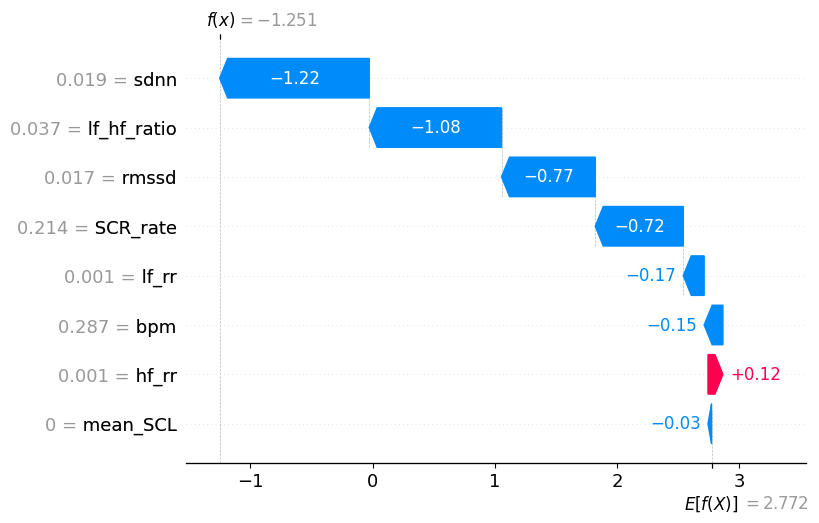

LogReg accuracy over 1 rounds: 0.3
Model evaluation metrics for LogReg:
Precision: 0.21666666666666667
Recall: 0.8666666666666667
F1-score: 0.3466666666666666
AUC score: 0.5060606060606061
RF accuracy over 1 rounds: 0.3
Model evaluation metrics for RF:
Precision: 0.19642857142857142
Recall: 0.7333333333333333
F1-score: 0.30985915492957744
AUC score: 0.4575757575757575
XGB accuracy over 1 rounds: 0.3
Model evaluation metrics for XGB:
Precision: 0.21666666666666667
Recall: 0.8666666666666667
F1-score: 0.3466666666666666
AUC score: 0.5060606060606061




In [10]:
# TRAIN ON ASCERTAIN AND TEST ON WESAD
importlib.reload(train)
importlib.reload(dr_w)
importlib.reload(dt)


# for j, phases_wesad in enumerate(model_phases_wesad):
#     print(f"WESAD PHASES {phases_wesad} " + "-"*50)
#     phases_wesad = [phases_wesad]
x_a, y_a = train.Train_ASCERTAIN.get_ascertain_data(metrics, verbose=False, label_type=asc_label_type, threshold=asc_threshold, normalize=True)
# x_b, y_b = train.Train_WESAD.get_wesad_data(metrics, phases_wesad, verbose=False, label_type=wesad_label_type, threshold=threshold, normalize=True)
x_b, y_b = train.Train_WESAD.get_wesad_data(metrics, model_phases_wesad, verbose=False, label_type=wesad_label_type, threshold=threshold, normalize=True)
# drop subjects with noisy data
inds = pd.isnull(x_a).any(axis=1).to_numpy().nonzero()[0]
x_a = x_a.drop(labels=inds, axis=0).reset_index(drop=True)
y_a = y_a.drop(labels=inds, axis=0).reset_index(drop=True)

# x = x[x['subject'] != 8.0]
# y = y[y['subject'] != 8.0]

x_a = x_a.drop(["phaseId"], axis=1)
x_b = x_b.drop(["phaseId"], axis=1)

# make sure subjects from different datasets aren't labeled with the same index
x_b["subject"] = x_b["subject"] + 500
y_b["subject"] = y_b["subject"] + 500

acc_results = {
    # "SVM": [],
    "LogReg": [],
    "RF": [],
    "XGB": []
}
reports = {
    # "SVM": [],
    "LogReg": [],
    "RF": [],
    "XGB": []
}
num_iters = 1
get_shap = True
for _ in range(num_iters):
    out = train.Train_Multi_Dataset.train_across_datasets(models, x_a, y_a, x_b, y_b, by_subject=True, save_metrics=True, test_size=test_size, is_resample=False, get_shap_values=True, drop_subject=True)
    for model_name in acc_results:
        acc_results[model_name].append(out[model_name][0])
        reports[model_name].append(out[model_name][1])
        if get_shap:
            try:
                shap.plots.waterfall(out[model_name][2][0])
            except Exception as e:
                print(out[model_name][2])

for model_name in acc_results.keys():
    acc = np.mean(acc_results[model_name])
    print(f"{model_name} accuracy over {num_iters} rounds: {acc}")
    if acc > 0:
        print(f"Model evaluation metrics for {model_name}:")
        p = np.mean([report["precision"] for report in reports[model_name]])
        r = np.mean([report["recall"] for report in reports[model_name]])
        f1 = np.mean([report["f1"] for report in reports[model_name]])
        auc = np.mean([report["auc"] for report in reports[model_name]])
        report = reports[model_name]
        print(f"Precision: {p}\nRecall: {r}\nF1-score: {f1}\nAUC score: {auc}")
    
print("\n")

WESAD PHASES ['Base', 'TSST', 'Medi_1', 'Fun', 'Medi_2'] --------------------------------------------------
Ratio of positive to negative labels (0.2727272727272727) is under 0.333, oversampling positive class.
Ratio of negative to positive labels (0.1721419185282523) is under 0.333, oversampling negative class.
y_train:
0    55
1    18
Name: label, dtype: int64
y_test:
1    1522
0     506
Name: label, dtype: int64
Model LogReg, Predictions: [0 1], [1931   97]
Calculating shap values
Model RF, Predictions: [0 1], [1664  364]
Calculating shap values
Model XGB, Predictions: [0 1], [1590  438]
Calculating shap values
[[ 2.49376459  0.39519282  0.0664703   0.53046521 -0.25156233  1.16240009
   0.91445823 -0.72501903]]
[0.26928875 0.08266628 0.15334513 0.08801367 0.06874838 0.16751801
 0.09938244 0.07103734]


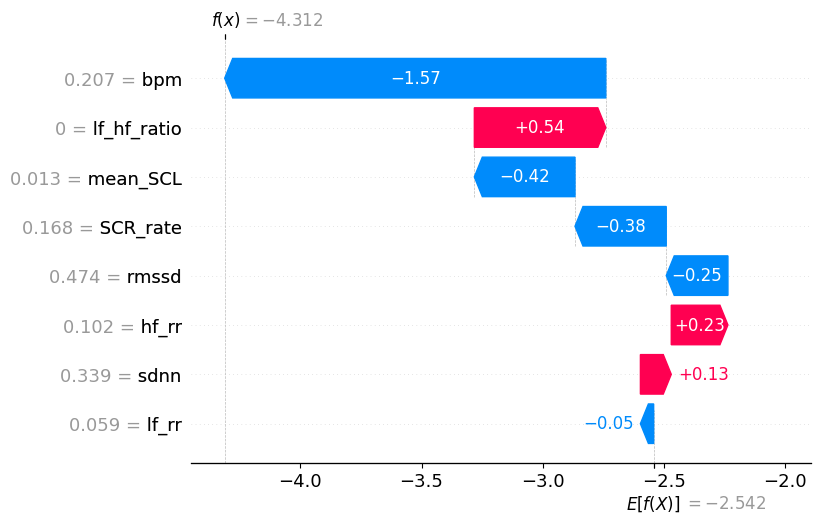

LogReg accuracy over 1 rounds: 0.27465483234714005
RF accuracy over 1 rounds: 0.3323471400394477
XGB accuracy over 1 rounds: 0.34714003944773175




In [7]:
# TRAIN ON WESAD AND TEST ON ASCERTAIN
importlib.reload(train)
importlib.reload(dr_w)
importlib.reload(dt)


print(f"WESAD PHASES {model_phases_wesad} " + "-"*50)
x_a, y_a = train.Train_WESAD.get_wesad_data(metrics, model_phases_wesad, verbose=False, label_type=wesad_label_type, threshold=threshold, normalize=True)
x_b, y_b = train.Train_ASCERTAIN.get_ascertain_data(metrics, verbose=False, label_type=asc_label_type, threshold=asc_threshold, normalize=True)
# drop subjects with noisy data
inds = pd.isnull(x_b).any(axis=1).to_numpy().nonzero()[0]
x_b = x_b.drop(labels=inds, axis=0).reset_index(drop=True)
y_b = y_b.drop(labels=inds, axis=0).reset_index(drop=True)

x_a = x_a.drop(["phaseId"], axis=1)
x_b = x_b.drop(["phaseId"], axis=1)

# make sure subjects from different datasets aren't labeled with the same index
x_b["subject"] = x_b["subject"] + 500
y_b["subject"] = y_b["subject"] + 500

acc_results = {
    # "SVM": [],
    "LogReg": [],
    "RF": [],
    "XGB": []
}
reports = {
    # "SVM": [],
    "LogReg": [],
    "RF": [],
    "XGB": []
}
num_iters = 1
get_shap = True
for _ in range(num_iters):
    out = train.Train_Multi_Dataset.train_across_datasets(models, x_a, y_a, x_b, y_b, by_subject=True, save_metrics=True, test_size=test_size, is_resample=True, get_shap_values=get_shap, drop_subject=True)
    for model_name in acc_results:
        acc_results[model_name].append(out[model_name][0])
        reports[model_name].append(out[model_name][1])
        if get_shap:
            try:
                shap.plots.waterfall(out[model_name][2][0])
            except Exception as e:
                print(out[model_name][2])

for model_name in acc_results.keys():
    acc = np.mean(acc_results[model_name])
    print(f"{model_name} accuracy over {num_iters} rounds: {acc}")
    if acc > 0.6:
        p = np.mean([report["precision"] for report in reports[model_name]])
        r = np.mean([report["recall"] for report in reports[model_name]])
        f1 = np.mean([report["f1"] for report in reports[model_name]])
        auc = np.mean([report["auc"] for report in reports[model_name]])
        report = reports[model_name]
        print(f"Report:\nPrecision: {p}\nRecall: {r}\nF1-score: {f1}\nAUC score: {auc}")
print("\n")